In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Localization - grid map

In [2]:
push!(LOAD_PATH, "src");
push!(LOAD_PATH, "/Users/mirko/Workspace/prob-comp/Distribution-Zoo/src")
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

In [3]:
Pose([0;0],0);
Measurement(1.0,π);

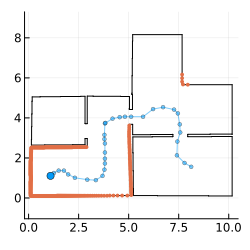

In [4]:
using JLD2
using StatsBase: mean
using Geometry: bounding_box, Segment
using LinearAlgebra: norm

fname = "data/data_2.jld2"
d = load_object(fname)

_segs = env_segs = d[:env][:segs];
    
_xs  = d[:motion][:x];
_hds = d[:motion][:hd];
_ps   = [Pose(x,hd) for (x,hd) in zip(_xs, _hds)];

_dxs  = d[:motion][:dx]
_dhds = d[:motion][:dhd]
_us   = [(dx,dhd) for (dx,dhd) in zip(_dxs, _dhds)]

_a    = d[:sensor][:a];
num_a = length(_a)
_zs   = d[:sensor][:z];
_ss   = [Measurement.(z,_a) for z in _zs]
_fov  = d[:sensor][:fov]
_zmax = d[:sensor][:zmax]

_T = length(_zs)

t = 1
# -----------------
plot(size=(250,250), aspect_ratio=:equal, legend=false)
plot!(_segs, c=:black)
plot!(_xs, marker=:o, label=nothing, markersize=2, c=col[1], alpha=0.5)
scatter!([_xs[t]], markersize=4, c=col[1])
scatter!(_ps[t], _ss[t], markersize=2, alpha=1, markerstrokewidth=0., marker=:o, c=col[2])

## Distributions we need

In [5]:
using MyUtils
using GenDistributionZoo: ProductDistribution

uniform2d = ProductDistribution(uniform, 2);

In [6]:
# We use `anywhere` to model a sensor failure, in which case
# we want to ignore its measurement. This is a bit of a hack, 
# but works
struct Anywhere <: Distribution{Vector{Float64}} end
const anywhere = Anywhere()

Gen.logpdf(::Anywhere, x::Vector{Float64}) = 0.0
Gen.random(::Anywhere) = [0.0;0.0]
(::Anywhere)() = Gen.random(Anywhere())
Gen.has_output_grad(::Anywhere)    = false
Gen.has_argument_grads(::Anywhere) = ();

## Pose prior

In [7]:
_bb = bounding_box(_segs);
# Caution, model depends on global variable.
# This isn't a "pure" function, in the 
# functional programming sense
@gen function pose_prior_model()
    x  ~ uniform2d([_bb[1]...],[_bb[2]...])
    hd ~ uniform(0,2π)
    return Pose(x,hd)
end;

## Motion model

In [8]:
"""
    q = motion_model(p, u)

Sample a new pose `q` given the previous pose `p`, and 
some control data `u = (dx, dhd)`.
"""
@gen function motion_model(p, u, std)
    dx, dhd = u
    x   ~ broadcasted_normal(p.x  + dx , [std, std])
    hd  ~ normal(p.hd + dhd, std)
    return p = Pose(x, hd)
end;

## Sensor model

The sensor model is the only part that depends on the map.
Since in this notebook we are only concerned with localization, not mapping,
we assume we are given a map `_m` of the environment, which we will now create.

In [9]:
function Plots.plot!(m::AbstractGridMap{CartesianIndex})
    vs = Matrix(m.vs')
    mat = expit.(vs)
    xticks = m.xs[1][1]-m.res/2:m.res:m.xs[end][1]+m.res/2
    yticks = m.xs[1][2]-m.res/2:m.res:m.xs[end][2]+m.res/2
    plot!(xticks, yticks, cgrad(:binary)(mat),  yflip = false)
end;

We simply compute the distance to the closest line segment, and apply a Gaussian.

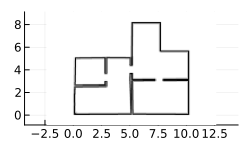

In [10]:
sig = 0.05
    
_m = SimpleGridMap((150,100), mean(bounding_box(_segs)); res=.1, prior=0.5);    
ds = [minimum(distance.([x],_segs)) for x in _m.xs]
vs = exp.(-1/2*(ds/sig).^2)
_m.vs = logit.(vs)
weigh!(_m)

# ---------------------
plot(size=(250,150), aspect_ratio=:equal, legend=false)
plot!(_m)

In [11]:
sensor_mix = HeterogeneousMixture([gridmapdist, anywhere]);

`sensor` mix is the same as integrating out the explicitly
modeled `failure` variable in the model below:
```julia
@gen function sensor_mixture_model(p,m, dropout)
    failure ~ bernoulli(dropout)
    y = [0.0;0.0]
    if !failure
        y ~ gridmapdist(p,m)
    end
    return y
end
```

Compute ...

```julia
_p = _ps[1]
y = gridmapdist(_p,_m)

ch0 = choicemap(:failure => false, :y => y);
ch1 = choicemap(:failure => true , :y => y);
(tr0, w0) = generate(sensor_mixture_model, (_p, _m, 0.5), ch0);
(tr1, w1) = generate(sensor_mixture_model, (_p, _m, 0.5), ch1);
```

and note that we have ...

```julia
log(exp(w0) + exp(w1)) == logpdf(sensor_mix, y, [0.5,0.5], _p, _m)
# >> true
```

In [12]:
y = euclidean(_zs[1][1], _a[1])
@btime Gen.logpdf(sensor_mix, y,[0.9,0.1], _ps[1], _m);

  2.411 μs (39 allocations: 1.72 KiB)


```julia
>> 2.429 μs (39 allocations: 1.72 KiB)
```
That means we can evaluate **400** individual measurements in **~1ms**.

### Fixed Resolution

In [12]:
@gen function sensor_model(p, m, num_a, dropout)
    ys = []
    for i = 1:num_a
        y = {:y => i} ~ sensor_mix([1.0 - dropout, dropout], p, m)
        push!(ys, y)
    end
    return ys
end;

In [14]:
ys = euclidean.(_zs[1], _a)
ch = choicemap([(:y => i) => ys[i] for i=1:num_a]...)


@btime simulate(sensor_model, (_ps[1], _m, $num_a, 0.1));
@btime generate(sensor_model, (_ps[1], _m, $num_a, 0.1), ch);

  90.632 ms (22292 allocations: 106.79 MiB)
  1.246 ms (17526 allocations: 770.47 KiB)


```julia
>> simulate 96.750 ms (22254 allocations: 106.11 MiB)
>> generate  1.247 ms (17526 allocations: 770.47 KiB)
```

The measurements are observed variables, so we are more interested in the performance of generating traces (via `generate`) with given contraints (`ch`) than simulating a trace from scratch (via `simulate`).

Depending on the application 1.247 ms for an evaluation is still slow. Since the runtime is linear in the number of measurements, one way to speed things up
is to simply reduce the number of measurements, or just evaluate a subset (specified by a set of indices `inds`).

### Multi Resolution

In [13]:
@gen function sensor_model_multires(p, m, inds, dropout)
    ys = []
    for i in inds
        y = {:y => i} ~ sensor_mix([1.0 - dropout, dropout], p, m)
        push!(ys, y)
    end
    return ys
end;

In [16]:
ind1  = 1:1:num_a;
ind10 = 1:10:num_a;

println("Evaluate every measurement:")
@btime simulate(sensor_model_multires, (_ps[1], _m, $ind1,  0.1));
@btime generate(sensor_model_multires, (_ps[1], _m, $ind1 , 0.1), ch);

println("\nOnly evaluate every 10'th measurement:")
@btime simulate(sensor_model_multires, (_ps[1], _m, $ind10, 0.1));
@btime generate(sensor_model_multires, (_ps[1], _m, $ind10, 0.1), ch);

Evaluate every measurement:
  94.367 ms (22370 allocations: 108.17 MiB)
  1.253 ms (17528 allocations: 770.56 KiB)

Only evaluate every 10'th measurement:
  7.549 ms (2166 allocations: 9.03 MiB)
  128.795 μs (1786 allocations: 79.08 KiB)


Benchmarks without skipping any measurements:
```julia
>> simulate 95.775 ms (22313 allocations: 107.14 MiB)
>> generate  1.251 ms (17528 allocations: 770.56 KiB)
```

This is similar to the previous model, which is good. 
As expected we get a **~10x** speed up if we reduce the number 
of measurements by a factor of **10**:

```julia
>> simulate   7.668 ms (2185 allocations: 9.37 MiB)
>> generate 128.983 μs (1786 allocations: 79.08 KiB)
```

## Slam model

In [14]:
@gen function slam_model(T, m, us, num_a, dropout, u_std)
    # Collect the model's poses
    # and sensor measurements so 
    # we can return them later
    ps = []
    ss = []
    
    # Start the Markov chain; 
    # No motion, just the prior
    p = {1 => :pose}   ~ pose_prior_model()
    y = {1 => :sensor} ~ sensor_model(p, m, num_a, dropout)
    s = Measurement.(y)
    
    # Collect
    push!(ps, p)
    push!(ss, s)
    
    # Unfold the Markov chain
    for t=2:T     

        # Sample a new pose given the previous one 
        # and some control variables; 
        # This is the motion model.
        u = us[t-1]
        p = {t => :pose} ~ motion_model(p, u, u_std)

        # Sample observation from 
        # the sensor model
        y = {t => :sensor} ~ sensor_model(p, m, num_a, dropout)
        s = Measurement.(y)
        
        # Collect
        push!(ps, p)
        push!(ss, s)
    end
    
    return Dict(:ps => ps, :ss => ss)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing], var"##slam_model#319", Bool[0, 0, 0, 0, 0, 0], false)

In [15]:
@gen function slam_model_multires(T, m, us, inds, dropout, u_std)
    # Collect the model's poses
    # and sensor measurements so 
    # we can return them later
    ps = []
    ss = []
    
    # Start the Markov chain; 
    # No motion, just the prior
    p = {1 => :pose}   ~ pose_prior_model()
    y = {1 => :sensor} ~ sensor_model_multires(p, m, inds, dropout)
    s = Measurement.(y)
    
    # Collect
    push!(ps, p)
    push!(ss, s)
    
    # Unfold the Markov chain
    for t=2:T     

        # Sample a new pose given the previous one 
        # and some control variables; 
        # This is the motion model.
        u = us[t-1]
        p = {t => :pose} ~ motion_model(p, u, u_std)

        # Sample observation from 
        # the sensor model
        y = {t => :sensor} ~ sensor_model_multires(p, m, inds, dropout)
        s = Measurement.(y)
        
        # Collect
        push!(ps, p)
        push!(ss, s)
    end
    
    return Dict(:ps => ps, :ss => ss)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing], var"##slam_model_multires#320", Bool[0, 0, 0, 0, 0, 0], false)

In [16]:
typeof(1:10)

UnitRange{Int64}

In [335]:
function create_obs_choices(zs::AbstractVector, as::AbstractVector)
    ch = choicemap()
    for t=1:length(zs), i=1:length(as)
        y = euclidean.(zs[t],as)
        ch[t => :sensor => :y => i]= y[i]
    end
    return ch
end

function create_obs_choices(t::Int, inds, zs::AbstractVector, as::AbstractVector)
    ch = choicemap()
    for i in inds
        y = euclidean.(zs[t], as)
        ch[t => :sensor => :y => i]= y[i]
    end
    return ch
end

function create_obs_choices(ts::UnitRange{Int64}, inds, zs::AbstractVector, as::AbstractVector)
    ch = choicemap()
    for t=ts, i in inds
        y = euclidean.(zs[t], as)
        ch[t => :sensor => :y => i]= y[i]
    end
    return ch
end

create_obs_choices (generic function with 3 methods)

In [18]:
function get_p(tr, t)
    d = tr[]
    return d[:ps][t]
end

function get_first_p(tr)
    d = tr[]
    return d[:ps][1]
end

get_first_p (generic function with 1 method)

In [22]:
function project_z(tr, t)
    ws = []
    for i=1:length(_a)
        w = project(tr, select(t => :sensor => :y => i))
        push!(ws,w)
    end
    return ws
end

project_z (generic function with 1 method)

In [19]:
function Plots.plot!(tr::Gen.DynamicDSLTrace)
    T, m, = get_args(tr)
    ret = get_retval(tr)
    ps = ret[:ps]
    ss = ret[:ss]
    
    myplot = plot!(aspect_ratio=:equal)
    plot!(_segs, label=nothing, c=:black)

    for t=1:T
        scatter!([ps[t].x], label=nothing)
        scatter!(ps[t],ss[t], markerstrokewidth=0.0, c=col[2], alpha=0.25, label=nothing)
    end
    return myplot
end

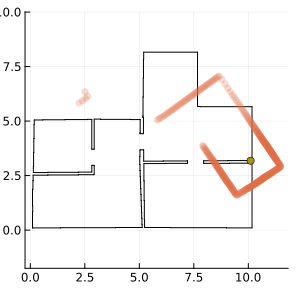

In [24]:
T = 1
dropout = 0.0
args = (T, _m, _us, length(_a), dropout, 0.1)
constr = create_obs_choices(_zs[1:T],_a)

tr,w = generate(slam_model, args, constr);

# -------------------------
plot(size=(300,300))
plot!(tr)

# Multi-resolution Experiments

## Time it

Trade-off between resolution (`S`) and time-steps (`T`) and particles (`N`) --
`S` is the step size when looping over measurements, i.e. larger `S` indicate a lower resolution

In [25]:
function time_importance_sampling(N,T,S; samples=nothing, evals=nothing)
    dropout = 1e-6
    constr  = create_obs_choices(1:_T, 1:num_a, _zs,_a);
    inds = 1:S:length(_a)
    args = (T, _m, _us, inds, dropout, 0.1)
    @btime importance_sampling($slam_model_multires, $args, $constr, $N) samples=samples evals=evals;
end

time_importance_sampling (generic function with 1 method)

In [ ]:
time_importance_sampling( 10, 1, 1);
time_importance_sampling(100, 1,10);
time_importance_sampling( 10,10,10);

```julia
>>  12.841 ms (173135 allocations: 7.54 MiB)
>>  13.897 ms (188393 allocations: 8.51 MiB)
>>  13.736 ms (181002 allocations: 8.15 MiB)
```

In [ ]:
time_importance_sampling( 1_000,  1,  1; samples=1, evals=1);
time_importance_sampling(10_000,  1, 10; samples=1, evals=1);
time_importance_sampling( 1_000, 10, 10; samples=1, evals=1);
time_importance_sampling(10_000,  5, 50; samples=1, evals=1);

```julia
>> 1.591 s (17732407 allocations: 766.55 MiB)
>> 1.835 s (18945877 allocations: 854.52 MiB)
>> 1.830 s (18525944 allocations: 827.58 MiB)
>> 3.019 s (24539968 allocations: 1.21 GiB)
```

## Visualizations

In [134]:
function exp_trade_off(N,T,S)
    inds   = 1:S:num_a
    args   = (T, _m, _us, inds, 1e-6, 0.1)
    constr = create_obs_choices(1:T, inds, _zs,_a);
    
    trs, ws,_ = importance_sampling(slam_model_multires, args, constr, N);
    
    trs    = trs[ws.>-Inf]
    ws     = ws[ws.>-Inf]
    scores = get_score.(trs)
    
    perm = sortperm(ws)
    
    trs    = trs[perm]
    ws     = peak_to_peak(ws[perm])
    scores = peak_to_peak(scores[perm]);
    
    return trs, ws, scores
end

exp_trade_off (generic function with 1 method)

In [135]:
N = 100
T = 5
S = 20

for i=1:3
    trs,ws,scores = exp_trade_off(N,T,S)
    println("$(i) done.");flush(stdout);
    # ---------------------------
    myplot = plot(size=(300,300), legend=nothing,  fmt = :png, title="N=$(N) S=$(S) T=$(T)")
    for (tr,w,sc) in zip(trs,ws,scores)
        p = get_first_p(tr)
        plot!([p.x,p.x + 0.5*unit_vec(p.hd)], c=cgrad(:viridis)[w], linewidth=4)
    end
    plot!(_segs, c=:black, linewidth=2)
    p = _ps[1]
    savefig("_imgs/skip_measures_N$(N)_S$(S)_T$(T)_i$(i).png")
    println("img saved.");flush(stdout);
end

1 done.
img saved.
2 done.
img saved.
3 done.
img saved.


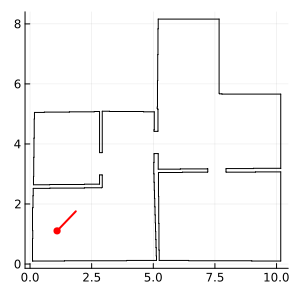

"/Users/mirko/Workspace/prob-comp/prob-slam-in-gen/notebooks/_imgs/correct_pose.png"

In [105]:
# ---------------------------
myplot = plot(size=(300,300), legend=nothing)
plot!(_segs, c=:black, linewidth=1)
p = _ps[1]
plot!([p.x,p.x + 1*unit_vec(p.hd)], c=:red, linewidth=2)
scatter!([p.x], c=:red, markerstrokewidth=0, markersize=4)
display(myplot)
savefig("_imgs/correct_pose.png")

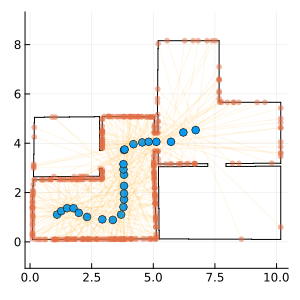

"/Users/mirko/Workspace/prob-comp/prob-slam-in-gen/notebooks/_imgs/measurement_S25_T25.png"

In [106]:
T = 25
S = 25
inds =  1:S:num_a

myplot = plot(size=(300,300), aspect_ratio=:equal, legend=false)
plot!(_segs, c=:black)

for t=1:T

    plot!.([[_xs[t], euclidean(s)*_ps[t]] for s in _ss[t][inds]], c=:orange, alpha=0.1)
    scatter!(_ps[t], _ss[t][inds], markersize=3, alpha=.5, markerstrokewidth=0., marker=:o, c=col[2])
    scatter!([_xs[t]], marker=:o, label=nothing, markersize=4, c=col[1], alpha=1.)
end
display(myplot)
savefig("_imgs/measurement_S$(S)_T$(T).png")

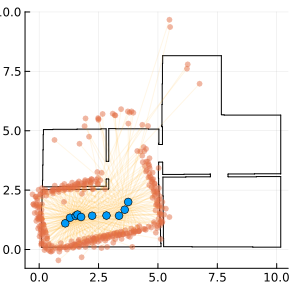

"/Users/mirko/Workspace/prob-comp/prob-slam-in-gen/notebooks/_imgs/noisy_measurement_S10_T10.png"

In [121]:
N = 100
T = 10
S = 10
inds =  1:S:num_a

trs, ws, scores = exp_trade_off(N,T,S)
tr = trs[end]
d = tr[]
ps = d[:ps]
ps = [p/ps[1]*_ps[1] for p in ps]
ss = d[:ss]



myplot = plot(size=(300,300), aspect_ratio=:equal, legend=false)
plot!(_segs, c=:black)

for t=1:T

    plot!.([[ps[t].x, euclidean(s)*ps[t]] for s in ss[t]], c=:orange, alpha=0.1)
    scatter!(ps[t], ss[t], markersize=3, alpha=.5, markerstrokewidth=0., marker=:o, c=col[2])
end
for t=1:T
    scatter!([ps[t].x], marker=:o, label=nothing, markersize=4, c=col[1], alpha=1.)
end
display(myplot)
savefig("_imgs/noisy_measurement_S$(S)_T$(T).png")

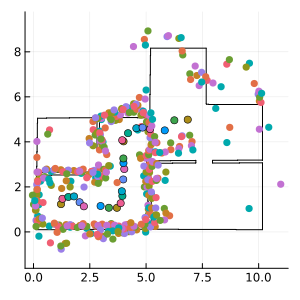

In [209]:
plot(size=(300,300));
plot!(trs[end])

# Particle filter - Basic

In [468]:
include("src/gen_utils.jl")

argdiffs (generic function with 1 method)

In [497]:
N = 2_000
S = 30
inds = 1:S:length(_a) 

T = 20
dropout = 1e-6
motion_noise = 0.01
args = (_m, _us, inds, dropout, motion_noise)
diffs = argdiffs([1; fill(0, length(args))])
choices = create_obs_choices(1:T, inds, _zs, _a);

ch = get_selected(choices, select(1))
state = initialize_particle_filter(slam_model_multires, (1, args...), ch, N);

println("N = $(N)")
println("S = $(S)")
println("PF steps = $(T)")
println("")
for t=2:T
    ch = get_selected(choices, select(t))
    # maybe_resample!(state, ess_threshold=N/2)
    @time particle_filter_step!(state, (t,args...), diffs, ch) 
end

N = 2000
S = 30
PF steps = 20

  0.664307 seconds (3.60 M allocations: 176.921 MiB, 53.29% gc time)
  0.503424 seconds (5.64 M allocations: 272.872 MiB)
  0.919082 seconds (7.68 M allocations: 368.861 MiB, 29.27% gc time)
  0.985653 seconds (9.72 M allocations: 464.784 MiB, 18.82% gc time)
  1.128148 seconds (11.75 M allocations: 560.527 MiB, 16.14% gc time)
  1.305116 seconds (13.76 M allocations: 655.676 MiB, 15.60% gc time)
  1.513996 seconds (15.78 M allocations: 751.065 MiB, 14.95% gc time)
  2.021816 seconds (17.81 M allocations: 847.653 MiB, 25.84% gc time)
  2.003054 seconds (19.82 M allocations: 942.842 MiB, 19.30% gc time)
  2.877561 seconds (21.83 M allocations: 1.019 GiB, 38.96% gc time)
  2.431423 seconds (23.84 M allocations: 1.114 GiB, 21.95% gc time)
  2.639045 seconds (25.84 M allocations: 1.207 GiB, 20.89% gc time)
  2.895819 seconds (27.83 M allocations: 1.299 GiB, 21.69% gc time)
  3.735947 seconds (29.82 M allocations: 1.391 GiB, 34.58% gc time)
  3.244743 seconds 

Runtimes of the **non-static** vanilla slam model:
```julia
N = 2000
S = 30
PF steps = 20

  0.293728 seconds (3.60 M allocations: 176.924 MiB)
  0.704061 seconds (5.64 M allocations: 272.865 MiB, 31.36% gc time)
  0.854038 seconds (7.68 M allocations: 368.858 MiB, 25.66% gc time)
  0.802533 seconds (9.72 M allocations: 464.800 MiB)
  1.209919 seconds (11.75 M allocations: 560.563 MiB, 17.77% gc time)
  1.365253 seconds (13.77 M allocations: 655.750 MiB, 16.27% gc time)
  1.851596 seconds (15.79 M allocations: 751.179 MiB, 28.38% gc time)
  1.721626 seconds (17.81 M allocations: 847.829 MiB, 16.76% gc time)
  2.137956 seconds (19.83 M allocations: 943.092 MiB, 14.56% gc time)
  3.183427 seconds (21.84 M allocations: 1.019 GiB, 35.49% gc time)
  3.278626 seconds (23.85 M allocations: 1.114 GiB, 23.40% gc time)
  2.956691 seconds (25.86 M allocations: 1.207 GiB, 17.01% gc time)
  3.547049 seconds (27.85 M allocations: 1.299 GiB, 26.65% gc time)
  4.231510 seconds (29.85 M allocations: 1.392 GiB, 28.61% gc time)
  4.653159 seconds (31.83 M allocations: 1.484 GiB, 19.95% gc time)
  3.878184 seconds (33.81 M allocations: 1.576 GiB, 16.22% gc time)
  4.973964 seconds (35.78 M allocations: 1.668 GiB, 33.90% gc time)
  4.128428 seconds (37.74 M allocations: 1.759 GiB, 18.61% gc time)
  4.401095 seconds (39.70 M allocations: 1.850 GiB, 20.56% gc time)
```

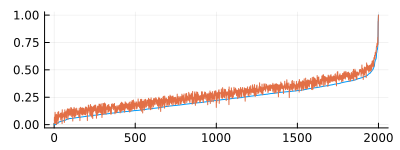

In [495]:
trs = state.traces
ws  = state.log_weights;
scores = get_score.(trs)

perm = sortperm(ws)
trs = trs[perm]
ws  = ws[perm]
scores = scores[perm]

ws     = peak_to_peak(ws)
scores = peak_to_peak(scores)

plot(size=(400,150), legend=nothing)
plot!(ws)
plot!(scores)

In [496]:
# ---------------------------
myplot = plot(size=(300,300), legend=nothing,  fmt = :png, title="N=$(N) S=$(S) T=$(T)")
for (tr,w,sc) in zip(trs,ws,scores)
    p = get_first_p(tr)
    plot!([p.x,p.x + 0.5*unit_vec(p.hd)], c=cgrad(:viridis)[w], linewidth=4)
end
plot!(_segs, c=:black, linewidth=2)
# savefig("_imgs/skip_measures_N$(N)_S$(S)_T$(T)_i$(i).png")
display(myplot)

LoadError: ArgumentError: invalid index: :ps of type Symbol

In [487]:
function Plots.plot(tr::Gen.DynamicDSLTrace)
    T, m, = get_args(tr)
    ret = get_retval(tr)
    ps = ret[:ps]
    ss = ret[:ss]
    
    myplot = plot(aspect_ratio=:equal)
    plot!(_segs, label=nothing, c=:black)

    for t=1:T
        scatter!([ps[t].x], label=nothing, c=col[1])
        scatter!(ps[t],ss[t], markerstrokewidth=0.0, c=col[2], alpha=0.25, label=nothing)
    end
    return myplot
end

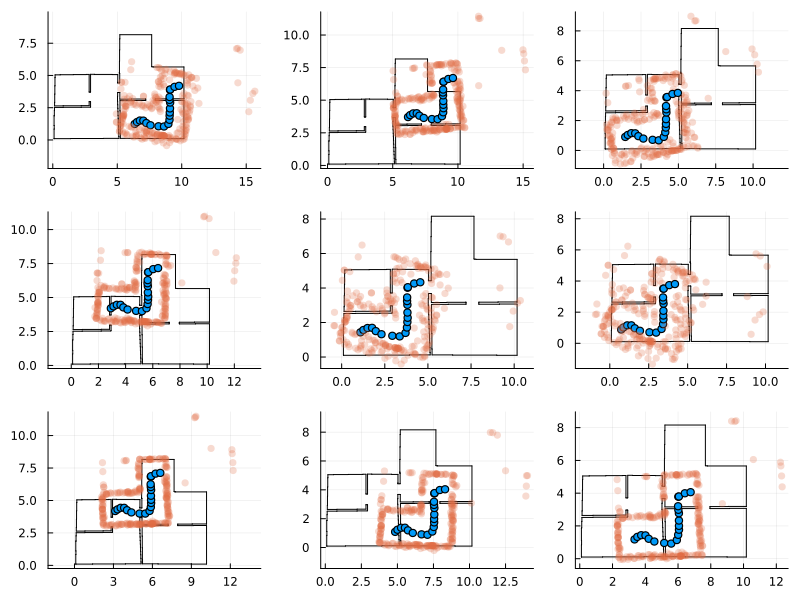

In [488]:
plot([plot(tr) for tr in trs[end-9+1:end]]..., layout=(3, 3), size=(800,600))

In a `Gen.update`, can I tell it that it does not need to re-evaluate a bunch of variables, because their logprobs won't change.  Do I need `static` for that?

```julia
for t=2:T
    tr,w = generate(model, (t-1,), obs_up_to(t-1));
    @time update(tr, (t,), (UnknownChange(),), obs(t))
end

6.0 ms
8.0 ms
10.0 ms
14.0 ms
15.0 ms
17.0 ms
20.0 ms
22.0 ms
24.0 ms
```

In [110]:
T = 10
S = 1
inds = 1:S:length(_a) 


dropout = 1e-6
motion_noise = 0.01
args = (_m, _us, inds, dropout, motion_noise)
diffs = argdiffs([1; fill(0, length(args))])

for t=2:T
    choices = create_obs_choices(1:t-1, inds, _zs, _a);    
    tr,w = generate(slam_model_multires, (t-1,args...), choices);
    ch = create_obs_choices(t, inds, _zs, _a)
    b = @benchmark update($tr, ($t, $args...), $diffs, $ch) samples=1 evals=1
    println("~ $(ceil(mean(b.times)/1e6)) ms")
end

6.0 ms
8.0 ms
10.0 ms
14.0 ms
15.0 ms
17.0 ms
20.0 ms
22.0 ms
24.0 ms


> "So if `model` is an `Unfold` combinator, things will work fine. If `model` contains a call to an `Unfold` combinator, then `model` should be written in the static modeling language" -- Xuan

# Static Model

In [424]:
@gen function slam_kernel(t, state, m, us, inds, dropout, u_std)
    
        p,_ = state
        u = us[t]
    
        p = {:pose}   ~ motion_model(p, u, u_std)
        y = {:sensor} ~ sensor_model_multires(p, m, inds, dropout)
        
    
    return (p, y)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [425]:
@gen (static) function static_slam_model(T, m, us, inds, dropout, u_std)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p = { :pose   } ~ pose_prior_model()
    y = { :sensor } ~ sensor_model_multires(p, m, inds, dropout)
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p,nothing), m, us, inds, dropout, u_std)
    
    return [(p,y);chain]
end

Gen.@load_generated_functions

In [426]:
function create_obs_choices′(t::Int, inds, zs::AbstractVector, as::AbstractVector)
    ch = choicemap()
    for i in inds
        y = euclidean.(zs[t], as)
        if t==1
            addr  = :sensor => :y => i
        else
            addr  = :chain => t-1 => :sensor => :y => i
        end
        ch[addr]= y[i]
    end
    return ch
end

function create_obs_choices′(ts::UnitRange{Int64}, inds, zs::AbstractVector, as::AbstractVector)
    ch = choicemap()
    for t=ts, i in inds
        y = euclidean.(zs[t], as)
        if t==1
            addr  = :sensor => :y => i
        else
            addr  = :chain => t-1 => :sensor => :y => i
        end
        ch[addr]= y[i]
    end
    return ch
end

create_obs_choices′ (generic function with 2 methods)

In [427]:
T = 0
S = 100
inds = 1:S:length(_a)
args = (T, _m, _us, inds, dropout, 0.1)
ch = create_obs_choices′(1:T-1,inds,_zs,_a)
tr,w = generate(static_slam_model, args, ch);

In [430]:
ch = create_obs_choices′(1:1,inds,_zs,_a)

│
└── :sensor
    │
    └── :y
        │
        ├── 1 : [-1.3134621886763316, -1.6085272651635464e-16]
        │
        ├── 271 : [9.194897619967016e-17, 1.5016407385980777]
        │
        ├── 361 : [-1.3134621886763311, 1.608527265163546e-16]
        │
        ├── 31 : [-0.922435214725064, -0.5325682195315058]
        │
        ├── 121 : [1.4965908058682025, -2.5921713139041764]
        │
        ├── 331 : [-0.8698348134343463, 0.5021993636868276]
        │
        ├── 61 : [-0.511057551640291, -0.8851776450327397]
        │
        ├── 151 : [3.5002432104659134, -2.0208663597916545]
        │
        ├── 181 : [2.205516608453954, 5.567506650319879e-29]
        │
        ├── 241 : [0.7250411798219493, 1.2558081610312986]
        │
        ├── 211 : [1.3086657544673406, 0.7555585256209636]
        │
        ├── 91 : [8.021780643106388e-17, -1.310056197213999]
        │
        └── 301 : [-0.5286381191253696, 0.9156280811427893]


In [522]:
N = 2_000
S = 30
inds = 1:S:length(_a) 

T = 20
dropout = 1e-1
motion_noise = 0.1
args = (_m, _us, inds, dropout, motion_noise)
diffs = argdiffs([1; fill(0, length(args))])



ch = create_obs_choices′(1:1,inds,_zs,_a)
state = initialize_particle_filter(static_slam_model, (0, args...), ch, N);

println("N = $(N)")
println("S = $(S)")
println("PF steps = $(T)")
println("")
for t=1:T-1
    ch = create_obs_choices′(t+1:t+1,inds,_zs,_a)
    @time particle_filter_step!(state, (t,args...), diffs, ch) 
end

N = 2000
S = 30
PF steps = 20

  0.128129 seconds (1.65 M allocations: 87.232 MiB)
  0.124669 seconds (1.65 M allocations: 87.223 MiB)
  0.123615 seconds (1.65 M allocations: 87.329 MiB)
  0.685457 seconds (1.65 M allocations: 87.299 MiB, 79.55% gc time)
  0.128084 seconds (1.64 M allocations: 87.174 MiB)
  0.121794 seconds (1.62 M allocations: 86.579 MiB)
  0.123252 seconds (1.63 M allocations: 86.876 MiB)
  0.426027 seconds (1.63 M allocations: 86.823 MiB, 67.41% gc time)
  0.123784 seconds (1.62 M allocations: 86.776 MiB)
  0.120292 seconds (1.61 M allocations: 86.402 MiB)
  0.120913 seconds (1.61 M allocations: 86.392 MiB)
  0.470172 seconds (1.61 M allocations: 86.654 MiB, 72.54% gc time)
  0.140331 seconds (1.61 M allocations: 86.483 MiB)
  0.124149 seconds (1.60 M allocations: 86.350 MiB)
  0.120635 seconds (1.59 M allocations: 86.218 MiB)
  0.120942 seconds (1.58 M allocations: 85.894 MiB)
  0.811081 seconds (1.58 M allocations: 85.938 MiB, 82.60% gc time)
  0.128172 seconds (1

**Static** slam model with **unfolded kernel** runtimes:
```julia
N = 2000
S = 30
PF steps = 20

  0.513946 seconds (1.65 M allocations: 87.249 MiB, 71.05% gc time)
  0.154650 seconds (1.65 M allocations: 87.235 MiB)
  0.147905 seconds (1.65 M allocations: 87.327 MiB)
  0.136177 seconds (1.65 M allocations: 87.291 MiB)
  0.135017 seconds (1.64 M allocations: 87.156 MiB)
  0.143113 seconds (1.62 M allocations: 86.598 MiB)
  0.143353 seconds (1.63 M allocations: 86.911 MiB)
  0.125939 seconds (1.63 M allocations: 86.851 MiB)
  0.124319 seconds (1.62 M allocations: 86.801 MiB)
  0.539516 seconds (1.61 M allocations: 86.413 MiB, 73.48% gc time)
  0.156771 seconds (1.61 M allocations: 86.399 MiB)
  0.155770 seconds (1.61 M allocations: 86.633 MiB)
  0.163995 seconds (1.61 M allocations: 86.460 MiB)
  0.162977 seconds (1.60 M allocations: 86.326 MiB)
  0.143468 seconds (1.59 M allocations: 86.215 MiB)
  0.141224 seconds (1.58 M allocations: 85.849 MiB)
  0.159520 seconds (1.58 M allocations: 85.908 MiB)
  0.146434 seconds (1.57 M allocations: 85.530 MiB)
  0.156174 seconds (1.57 M allocations: 85.547 MiB)
```

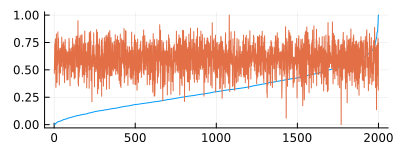

In [523]:
trs = state.traces
ws  = state.log_weights;
scores = get_score.(trs)

perm = sortperm(ws)
trs = trs[perm]
ws  = ws[perm]
scores = scores[perm]

ws     = peak_to_peak(ws)
scores = peak_to_peak(scores)

plot(size=(400,150), legend=nothing)
plot!(ws)
plot!(scores)

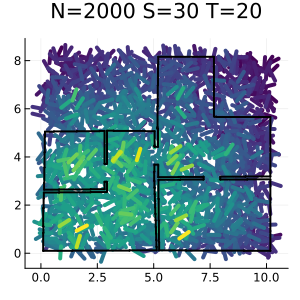

In [524]:
# ---------------------------
myplot = plot(size=(300,300), legend=nothing,  fmt = :png, title="N=$(N) S=$(S) T=$(T)")
for (tr,w,sc) in zip(trs,ws,scores)
    r = tr[]
    p = r[1][1]
    plot!([p.x,p.x + 0.5*unit_vec(p.hd)], c=cgrad(:viridis)[w], linewidth=4)
end
plot!(_segs, c=:black, linewidth=2)
# savefig("_imgs/skip_measures_N$(N)_S$(S)_T$(T)_i$(i).png")
display(myplot)

In [525]:
function plot_static_tr(tr::StaticIRTrace)
    T, m, = get_args(tr)
    rs = tr[]
    ps = [r[1] for r in rs]
    ss = [Measurement.(r[2]) for r in rs]
    
    myplot = plot(aspect_ratio=:equal)
    plot!(_segs, label=nothing, c=:black)

    for t=1:T
        scatter!([ps[t].x], label=nothing, c=col[1])
        scatter!(ps[t],ss[t], markerstrokewidth=0.0, c=col[2], alpha=0.25, label=nothing)
    end
    return myplot
end

plot_static_tr (generic function with 3 methods)

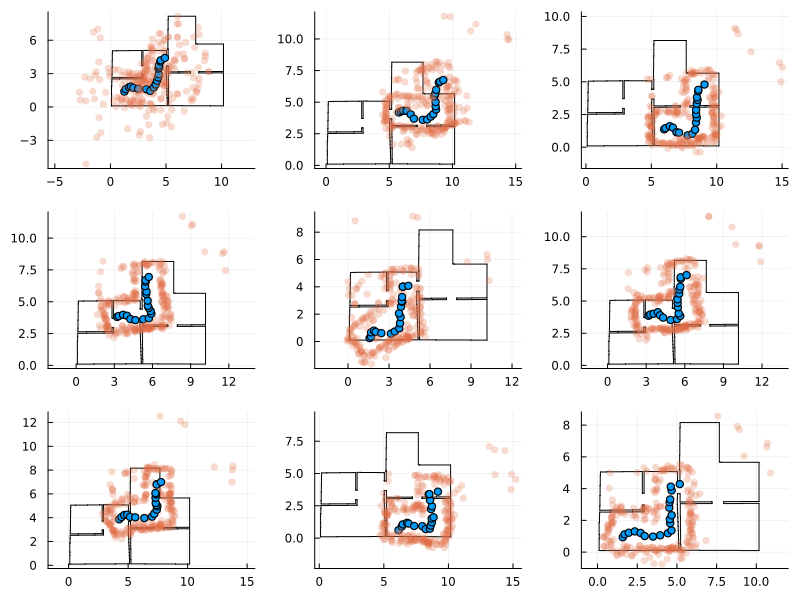

In [526]:
plot([plot_static_tr(tr) for tr in trs[end-9+1:end]]..., layout=(3, 3), size=(800,600))